# Events - Qualitatve analysis (per event)

## Goal - Quantitatively and qualitatively determine the quality of the reconstructions and samples generated by the models

In [1]:
# General Imports
import numpy as np
import sys
import os

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

# Dataset imports
from torch.utils.data import DataLoader
from io_utils.data_handling import WCH5Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# Scipy imports
from scipy import stats

# Plotting imports
from plot_utils import plot_utils
import matplotlib.pyplot as plt

## Steps :

### 1. Load the actual, reconstructed and synthetic events generated by the model.
### 2. Load another set of actual events with the same number of examples as the reconstructed or sampled events.
### 3. Sum over the event dimensions to have total charge per event metrics
### 4. Perform the KS test on the actual vs reconstructed events and plot the histograms overlaid
### 5. Perform the KS test on the actual vs synthetic events and plot the histograms overlaid
### 6. Perform the KS test on the actual vs actual events and plot the histograms overlaid

## Load the actual, reconstructed and synthetic events generated by the model

In [2]:
# Load the actual and reconstructed events
dump_dir = "/home/akajal/WatChMaL/VAE/dumps/" + "20190905_220747" + "/"
val_dump_arr = np.load(dump_dir + "test_validation_iteration_dump.npz")

np_actual = val_dump_arr["events"]
np_recon  = val_dump_arr["recon"]

# Load the synthetic generated events
dump_dir = "/home/akajal/WatChMaL/VAE/dumps/" + "20190905_182101" + "/"
model_status = "trained"
np_arr_path = dump_dir + "samples/" + "ENet" + "_" + model_status + ".npz"
sample_dump_arr = np.load(np_arr_path)

np_samples = sample_dump_arr["samples"]

In [3]:
print(np_actual.shape)
print(np_recon.shape)
print(np_samples.shape)

(64, 1024, 16, 40, 19)
(64, 1024, 16, 40, 19)
(64, 1024, 16, 40, 19)


## Load another set of actual events from another subset of dataset

In [4]:
# Create the dataset
dset=WCH5Dataset("/fast_scratch/nuVAE_data/9Mevents_IWCD_angles.h5",
                 0.2, 0.1, 0.1, 0.1, "train_ae_or_vae_only",
                 shuffle=True, reduced_dataset_size=None)

val_iter=DataLoader(dset, batch_size=65536, shuffle=False,
                     sampler=SubsetRandomSampler(dset.val_indices))

np_actual_2 = next(iter(val_iter))[0].cpu().numpy()

## Sum over the event dimensions to have total charge per event metrics

In [10]:
np_actual, np_recon = np.sum(np_actual.reshape(64, 1024, -1), axis=2), np.sum(np_recon.reshape(64, 1024, -1), axis=2)
np_samples, np_actual_2 = np.sum(np_samples.reshape(64, 1024, -1), axis=2), np.sum(np_actual_2.reshape(64, 1024, -1), axis=2)

In [11]:
# Reshape the 5D arrays into 1D for plotting and comparing
np_actual, np_recon = np_actual.reshape(-1), np_recon.reshape(-1)
np_samples, np_actual_2 = np_samples.reshape(-1), np_actual_2.reshape(-1)

## Perform the KS test on the actual vs reconstructed events and plot the histograms overlaid

In [12]:
actual_vs_recon_ks, actual_vs_recon_p = stats.ks_2samp(np_actual, np_recon)

print("---------------------------------------------")
print("KS test for actual vs reconstructed events :")
print("---------------------------------------------")
print("KS statistic for actual vs reconstrcuted events : ", actual_vs_recon_ks)
print("P value for actual vs reconstucted events : ", actual_vs_recon_p)

---------------------------------------------
KS test for actual vs reconstructed events :
---------------------------------------------
KS statistic for actual vs reconstrcuted events :  0.0080108642578125
P value for actual vs reconstucted events :  0.029653771946682485


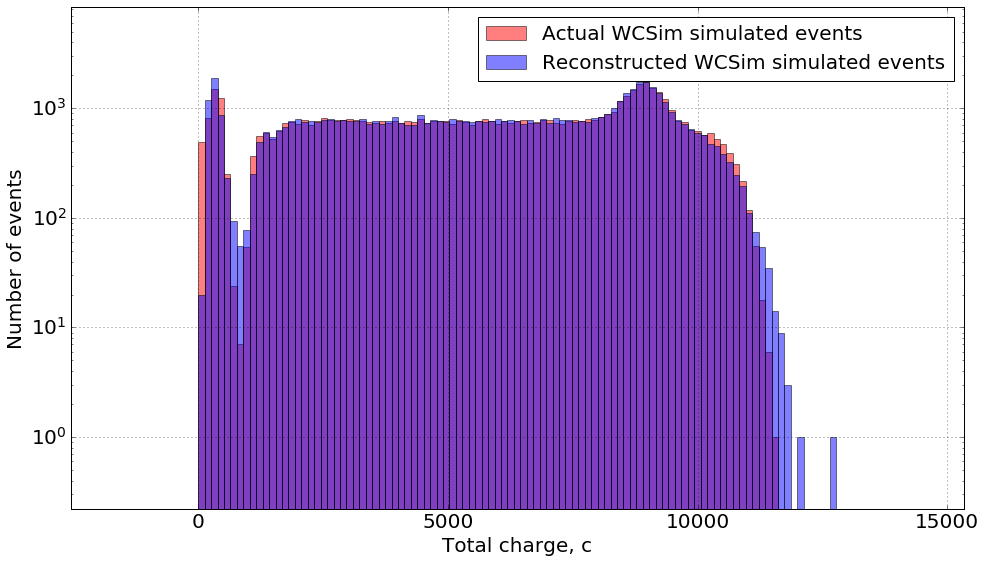

In [21]:
# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)
num_bins = 100

# Setup the bins beforehand
bins = np.linspace(min(np.amin(np_actual),np.amin(np_recon),0),
                   max(np.amax(np_actual),np.amax(np_recon)),
                   num_bins)

# Plot the histograms overlaid
plt.hist(np_actual, bins, density=False,
         label="Actual WCSim simulated events", color="red",
         alpha=0.5, stacked=False)

plt.hist(np_recon, bins, density=False,
         label="Reconstructed WCSim simulated events", color="blue",
         alpha=0.5, stacked=False)

# Setup the axes
ax.set_xlabel("Total charge, c", fontsize=20)
ax.set_ylabel("Number of events", fontsize=20)

plt.yscale("log")

plt.margins(0.2)
plt.grid(True)

plt.legend(loc="upper right", prop={"size":20})

plt.savefig("figures/actual_vs_reconstructed_sum_histogram.pdf", format="pdf", dpi=600)
plt.show()

## Perform the KS test on the actual vs synthetic events and plot the histograms overlaid

In [16]:
actual_vs_synthetic_ks, actual_vs_synthetic_p = stats.ks_2samp(np_actual, np_samples)

print("---------------------------------------------")
print("KS test for actual vs synthetic events :")
print("---------------------------------------------")
print("KS statistic for actual vs synthetic events : ", actual_vs_synthetic_ks)
print("P value for actual vs synthetic events : ", actual_vs_synthetic_p)

---------------------------------------------
KS test for actual vs synthetic events :
---------------------------------------------
KS statistic for actual vs synthetic events :  0.6398773193359375
P value for actual vs synthetic events :  0.0


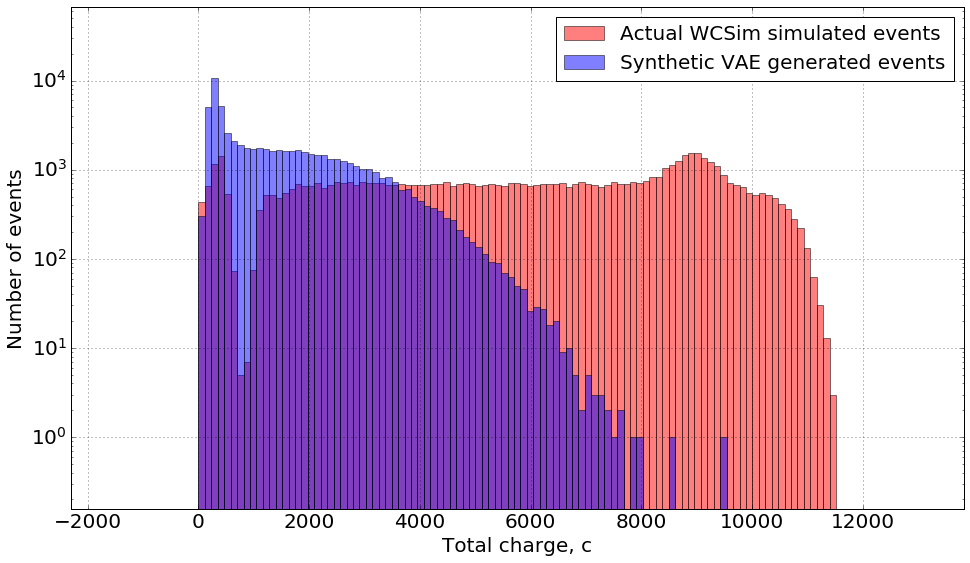

In [22]:
# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)
num_bins = 100

# Setup the bins beforehand
bins = np.linspace(min(np.amin(np_actual),np.amin(np_samples),0),
                   max(np.amax(np_actual),np.amax(np_samples)),
                   num_bins)

# Plot the histograms overlaid
plt.hist(np_actual, bins, density=False,
         label="Actual WCSim simulated events", color="red",
         alpha=0.5, stacked=False)

plt.hist(np_samples, bins, density=False,
         label="Synthetic VAE generated events", color="blue",
         alpha=0.5, stacked=False)

# Setup the axes
ax.set_xlabel("Total charge, c", fontsize=20)
ax.set_ylabel("Number of events", fontsize=20)

plt.yscale("log")

plt.margins(0.2)
plt.grid(True)

plt.legend(loc="upper right", prop={"size":20})

plt.savefig("figures/actual_vs_synthetic_sum_histogram.pdf", format="pdf", dpi=600)
plt.show()

## Perform the KS test on the actual vs actual events and plot the histograms overlaid

In [19]:
actual_vs_actual_2_ks, actual_vs_actual_2_p = stats.ks_2samp(np_actual, np_actual_2)

print("---------------------------------------------")
print("KS test for actual vs actual_2 events :")
print("---------------------------------------------")
print("KS statistic for actual vs actual_2 events : ", actual_vs_actual_2_ks)
print("P value for actual vs actual_2 events : ", actual_vs_actual_2_p)

---------------------------------------------
KS test for actual vs actual_2 events :
---------------------------------------------
KS statistic for actual vs actual_2 events :  1.0
P value for actual vs actual_2 events :  0.0


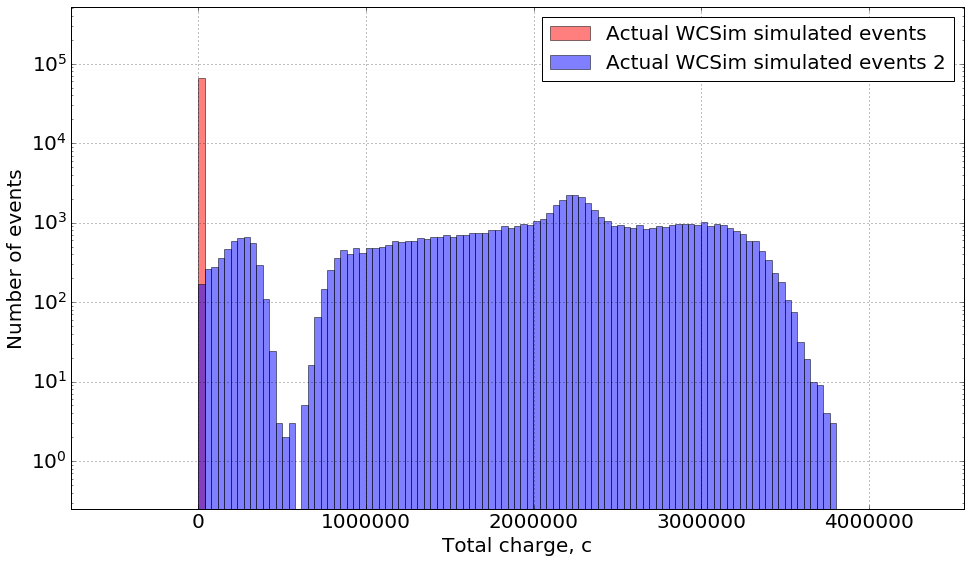

In [23]:
# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)
num_bins = 100

# Setup the bins beforehand
bins = np.linspace(min(np.amin(np_actual),np.amin(np_actual_2),0),
                   max(np.amax(np_actual),np.amax(np_actual_2)),
                   num_bins)

# Plot the histograms overlaid
plt.hist(np_actual, bins, density=False,
         label="Actual WCSim simulated events", color="red",
         alpha=0.5, stacked=False)

plt.hist(np_actual_2, bins, density=False,
         label="Actual WCSim simulated events 2", color="blue",
         alpha=0.5, stacked=False)

# Setup the axes
ax.set_xlabel("Total charge, c", fontsize=20)
ax.set_ylabel("Number of events", fontsize=20)

plt.yscale("log")

plt.margins(0.2)
plt.grid(True)

plt.legend(loc="upper right", prop={"size":20})

plt.savefig("figures/actual_vs_actual_2_sum_histogram.pdf", format="pdf", dpi=600)
plt.show()

## Perform the KS test on the actual events vs itself and plot the histograms overlaid

In [24]:
actual_vs_actual_ks, actual_vs_actual_p = stats.ks_2samp(np_actual, np_actual)

print("---------------------------------------------")
print("KS test for actual vs actual events :")
print("---------------------------------------------")
print("KS statistic for actual vs actual events : ", actual_vs_actual_ks)
print("P value for actual vs actual events : ", actual_vs_actual_p)

---------------------------------------------
KS test for actual vs actual events :
---------------------------------------------
KS statistic for actual vs actual events :  0.0
P value for actual vs actual events :  1.0


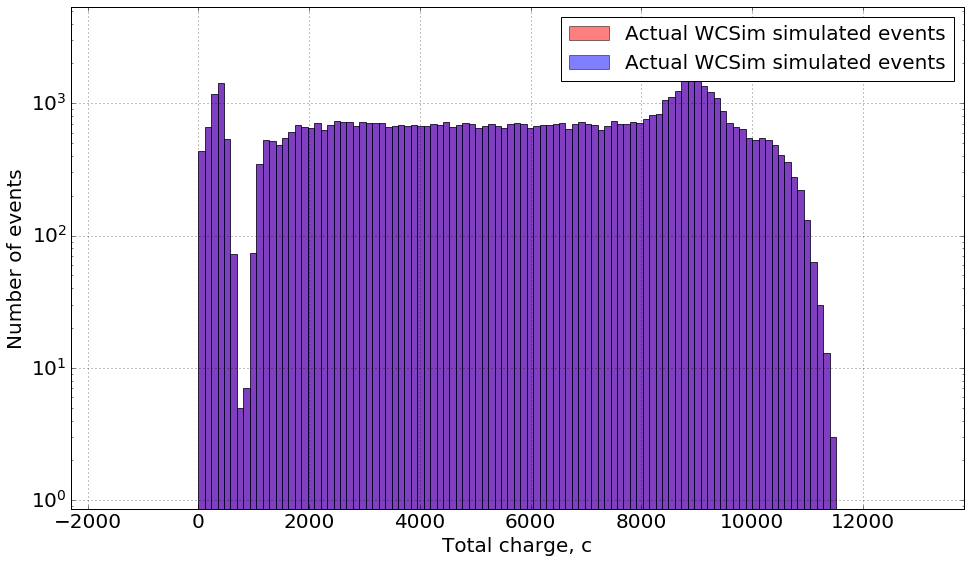

In [25]:
# Initialize the plot and corresponding parameters
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
ax.tick_params(axis="both", labelsize=20)
num_bins = 100

# Setup the bins beforehand
bins = np.linspace(min(np.amin(np_actual),np.amin(np_actual),0),
                   max(np.amax(np_actual),np.amax(np_actual)),
                   num_bins)

# Plot the histograms overlaid
plt.hist(np_actual, bins, density=False,
         label="Actual WCSim simulated events", color="red",
         alpha=0.5, stacked=False)

plt.hist(np_actual, bins, density=False,
         label="Actual WCSim simulated events", color="blue",
         alpha=0.5, stacked=False)

# Setup the axes
ax.set_xlabel("Total charge, c", fontsize=20)
ax.set_ylabel("Number of events", fontsize=20)

plt.yscale("log")

plt.margins(0.2)
plt.grid(True)

plt.legend(loc="upper right", prop={"size":20})

plt.savefig("figures/actual_vs_actual_sum_histogram.pdf", format="pdf", dpi=600)
plt.show()